# Geographic Gaps in CS Subfields

https://docs.google.com/document/d/1rjYFFJPjAgsiXR5c7fSpO4aEztlHhYbhAlcKaAC7hzI/edit

Question(s) to answer in this notebook:
## 1. How do countries cite each other?
## 2. How does geographic location drive the collaboration between researchers?

None of the questions in the paper address the size of a country's population, or the number of institutions/universities a country has. More the population or universities, more papers, more citations. We can control for this aspect.

Data:
- [Download](https://zenodo.org/record/6511057#.Y40_-dLMJkj)
- [Schema](https://learn.microsoft.com/en-us/academic-services/graph/reference-data-schema)

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import reverse_geocode
import pycountry

from IPython.display import display, clear_output

dataset_dir = "mag_dataset"

# https://seaborn.pydata.org/tutorial/color_palettes.html
    
cm = sns.light_palette("green", as_cmap=True)

# Get Conferences

In [2]:
col_names = ["ConferenceSeriesId", "Rank", "NormalizedName", "DisplayName", "PaperCount", "CitationCount"]
usecols = [0, 1, 2, 3, 4, 6]

ai_conf_series = pd.read_csv("ai_conf_series.csv")
sys_conf_series = pd.read_csv("SystemsConferenceSeries.txt", delimiter="\t", usecols = usecols, names = col_names)
interdis_conf_series = pd.read_csv("InterDisConferenceSeries.txt", delimiter="\t", usecols = usecols, names = col_names)
theory_conf_series = pd.read_csv("TheoryConferenceSeries.txt", delimiter="\t", usecols = usecols, names = col_names)

conf_series = [ai_conf_series, sys_conf_series, interdis_conf_series, theory_conf_series]
area_names = ["AI", "SYSTEM", "INTERDIS", "THEORY"]

# Q2: How does geographic location drive the collaboration between researchers?

In [147]:
def plot_citation_heat_map(matrix, country_index, num_countries_to_show = 20, scale = 1, file_name=None):

    fig,ax = plt.subplots()
    fig.set_figheight(5) #10
    fig.set_figwidth(10) #20

    matrix_to_show = matrix[:num_countries_to_show, :num_countries_to_show]
    country_names = country_index[:num_countries_to_show]
    matrix_to_show = matrix_to_show/scale

    sns.heatmap(matrix_to_show, annot=True, cmap="crest", fmt='3.0f', linewidths=.05,
                xticklabels=country_names, yticklabels=country_names, vmin=1000/scale) # vmax=
    plt.xlabel("Country")
    plt.ylabel("Country")
    
    plt.tight_layout()
    
    if file_name:
        plt.savefig(file_name)
    
    plt.show()
    
    return matrix_to_show, country_names

In [173]:
## Who (countries) are most cited in each country
## Column-Wise heatmaps

def columnwise_conditionalformat(matrix_to_show, country_names, area_name, color = 'Oranges', num_countries_to_show = 20, file_name=None):    
    
    df = pd.DataFrame(matrix_to_show, columns=country_names, index=country_names).iloc[::-1,:]
    
    nrows = len(df)
    ncols = len(df.columns)
    fig, ax = plt.subplots(figsize=(8,5)) # (15,10)
    for i in range(ncols):
        truthar = [True]*ncols
        truthar[i] = False
        mask = truthar = np.array(nrows * [truthar], dtype=bool)
        red = np.ma.masked_where(mask, df)
        ax.pcolormesh(red, cmap=color)

    for y in range(df.shape[0]):
        for x in range(df.shape[1]):
            x+=1
            cond = (x==(num_countries_to_show-y))
            if area_name == "AI":
                cond = (cond or (x==9 and y==8))
            elif area_name == "SYSTEM":
                cond = (cond or (x==10 and y==8))
            elif area_name == "THEORY":
                cond = (cond or (y==9 and x in [1,2,10]))
            x-=1
            plt.text(x+.5,y+.5,'%3.0f'% df.iloc[y, x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     color="white" if cond else "black" )
    
    plt.xticks(range(num_countries_to_show), country_names, rotation=90)
    plt.yticks(range(num_countries_to_show), country_names[::-1])
    plt.xlabel("Country")
    plt.ylabel("Country")
    
    plt.tight_layout()
    
    if file_name:
        plt.savefig(file_name)
    
    plt.show()

In [174]:
def create_matrix(paper_auth_aff_with_geo, num_countries = 10):
    
    df = paper_auth_aff_with_geo[["PaperId", "Aff_country"]]
    df = df.merge(df, on="PaperId", suffixes=("_left","_right")).drop_duplicates()
#     display(df)
    df = df.groupby(["Aff_country_left", "Aff_country_right"]).count().iloc[:,0].to_frame().rename(columns={"PaperId":"count"}).sort_values("count", ascending=False).reset_index()

    ## all countries
    countries_ref = pd.concat([df[["Aff_country_left", "count"]].rename(columns={"Aff_country_left":"country"}), 
                               df[["Aff_country_right", "count"]].rename(columns={"Aff_country_right":"country"})])\
                     .sort_values("count", ascending=False)
    countries = countries_ref["country"].unique()[:num_countries]
    
    # Create index for countries
    country_rev_index = {country:i for i, country in enumerate(countries)}
    
    ## create matrix
    matrix = np.zeros((num_countries, num_countries))
    
#     display(df)
    
    for _, row in df.iterrows():
        country1 = row["Aff_country_left"]
        country2 = row["Aff_country_right"]
        count = row["count"]
        if (country1 in countries) and (country2 in countries):
#             print(country1, country2, count)
            matrix[country_rev_index[country1], country_rev_index[country2]] = count
    
    ## clear diagonal
    for i in range(num_countries):
        matrix[i,i] = 0
        
    for paper, _df in paper_auth_aff_with_geo.groupby("PaperId"):
        paper_countries = _df["Aff_country"].unique()
        ## diagonal will contain only papers that are produced within the same country
        ## i.e, al authors from the same country
        if len(paper_countries)==1 and (paper_countries[0] in countries):
            matrix[country_rev_index[paper_countries[0]], country_rev_index[paper_countries[0]]] += 1
        
    return matrix, countries, country_rev_index

Starting AI...


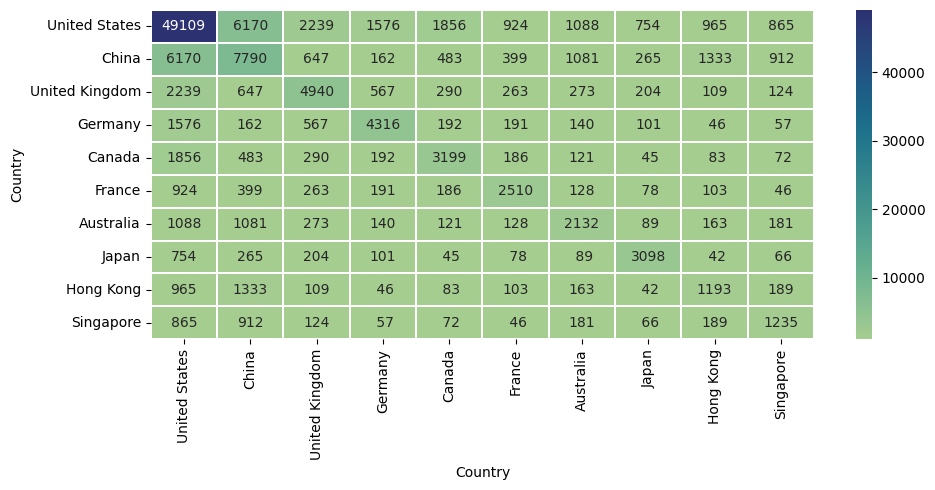

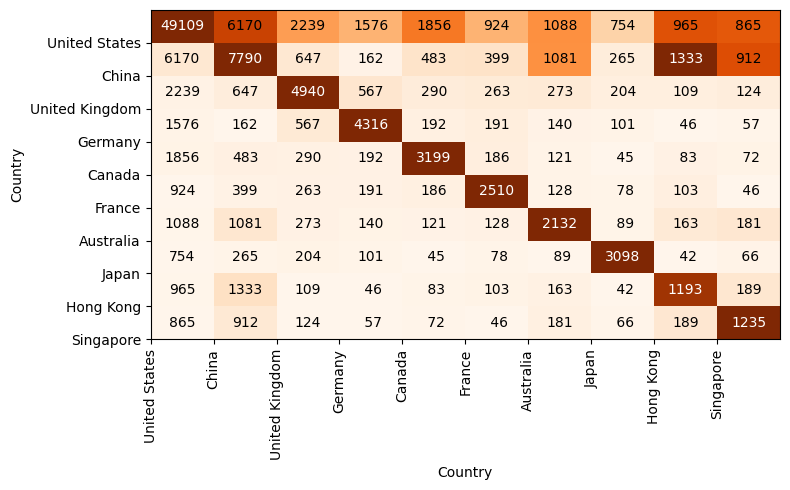

Starting SYSTEM...


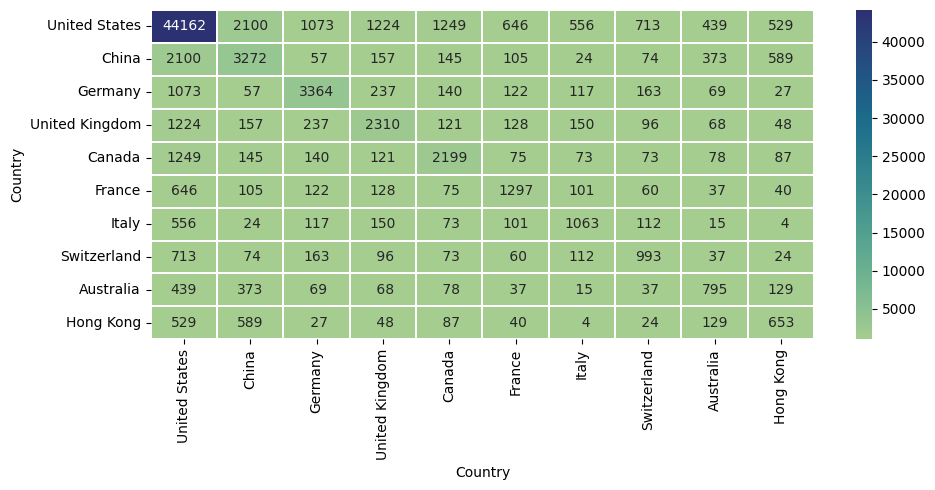

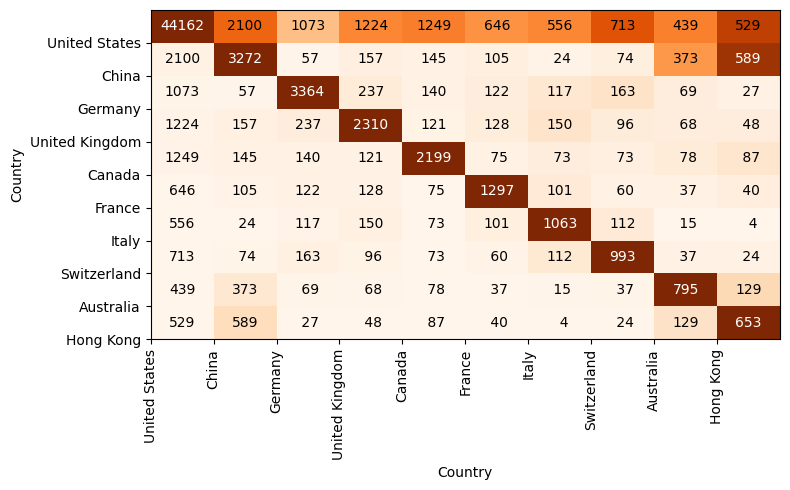

Starting INTERDIS...


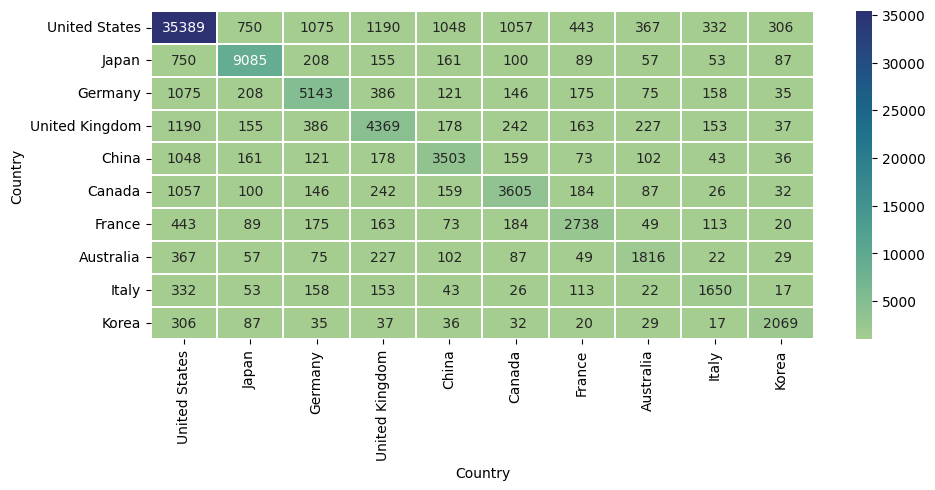

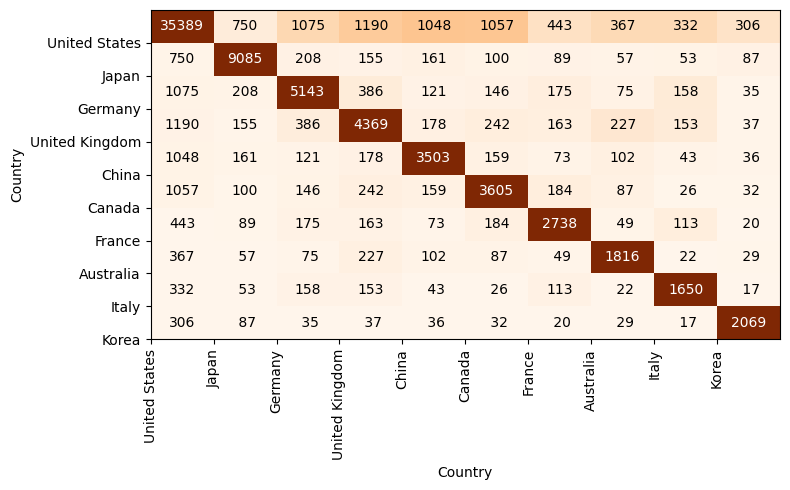

Starting THEORY...


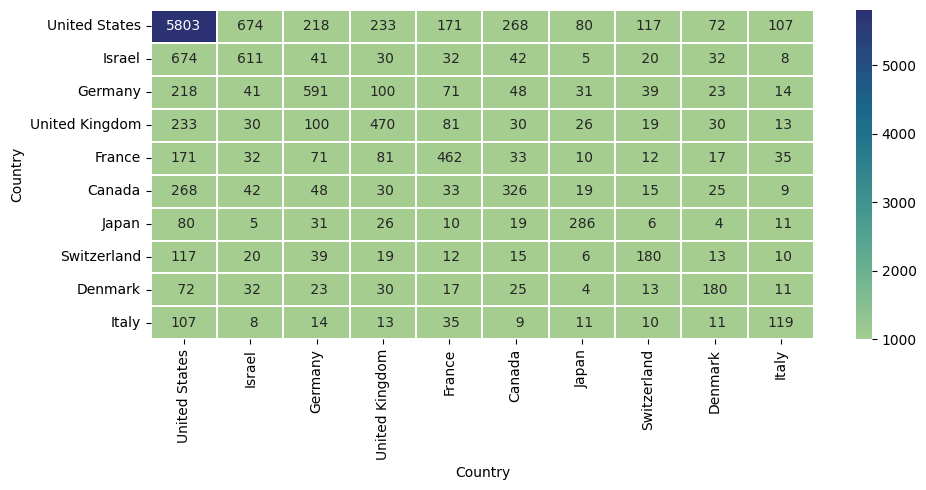

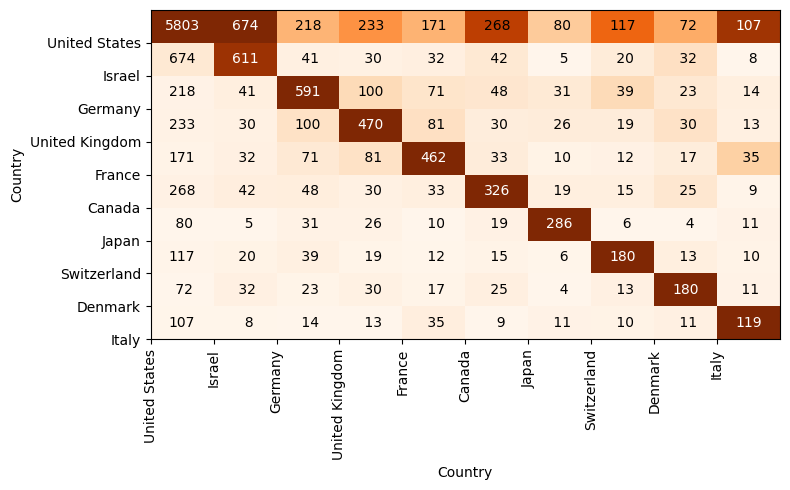

In [175]:
for area_name in area_names:
        
    print(f"Starting {area_name}...")

    paper_auth_aff_with_geo = pd.read_csv(area_name+"/paper_auth_aff_with_geo.csv")    
    
    matrix, country_index, country_rev_index = create_matrix(paper_auth_aff_with_geo)
    
    matrix_to_show, country_names = plot_citation_heat_map(matrix, country_index, num_countries_to_show = 10, file_name=area_name+"/collaboration_heatmap_10_countries.png")
    columnwise_conditionalformat(matrix_to_show, country_names, num_countries_to_show = 10, file_name=area_name+"/collaboration_columnheatmap_10_countries.png", area_name = area_name)